$\textbf{Selection of Depth and Areal Regions}$

$\text{In this tutorial we will see how to select the best region in the dataset using the PyCCAPT calibration module.}$

In [1]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# import libraries
import os
import numpy as np
import sys
import os.path as path
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, data_loadcrop, tools, data_tools
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.calibration_tools import dataset_path_qt
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.leap_tools import ccapt_tools, leap_tools

In [2]:
# Disable showing logging in Jupyter notebook
import logging, sys
logging.disable(sys.maxsize)

In [3]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [21]:
# check pytables library and install it
try:
    import tables
except:
    !conda install --yes --prefix {sys.prefix} pytables

In [22]:
tdc, det_diam, pulse_mode, flightPathLength_d, t0_d, max_tof = wd.dataset_tdc_selection()
display(tdc, pulse_mode, max_tof, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec', 'leap_epos', 'leap_pos'), value='su…

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

IntText(value=5000, description='Max tof:')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=51.74, description='t0:')

$\text{Path to the dataset}$

In [23]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value

max_tof_ini = max_tof.value # ns

dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]

variables.init()

variables.result_path = dataset_main_path + '/' + dataset_name + '/load_crop/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
        
# dataset name
filename = dataset_path
savename = variables.result_path + '//' + dataset_name + '_cropped' + '.h5'

# Create data farame out of hdf5 file dataset
dld_group_storage = data_loadcrop.fetch_dataset_from_dld_grp(filename, tdc=tdc_model, pulse_mode=pulse_mode_ini, max_tof=max_tof_ini)

print('Total number of Ions:', len(dld_group_storage))

Filename>> D:/pyccapt/tests/data/SS-420-1_data.h5
{'cropped_dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'oxcart': ['high_voltage', 'main_chamber_vacuum', 'num_events', 'pulse_voltage', 'temperature', 'time_counter'], 'tdc': ['channel', 'high_voltage', 'pulse_voltage', 'start_counter', 'time_data'], 'time': ['time_h', 'time_m', 'time_s']}
Total number of Ions: 6762021


$\textbf {Crop and select the stable projection(right side) of below plotted graph}$
<br>
<br>
$\text{In the Experiment history plot below you should select the ions. After selectiong the ions with a rectangle you can continue and run the next cell. }$

In [24]:
dld_group_storage

,high_voltage (V),pulse (V),start_counter,t (ns),x_det (cm),y_det (cm)
0,511.000000,511.000000,31425.0,85.025484,-1.423102,0.996490
1,516.997009,516.997009,42846.0,3282.458256,-2.088490,-1.977061
2,519.994019,519.994019,31756.0,1688.405310,2.330449,1.308490
3,521.990479,521.990479,14241.0,3585.328110,0.178286,2.470531
4,521.990479,521.990479,14241.0,3691.263636,0.092327,2.292245
...,...,...,...,...,...,...
6762016,12000.616211,12000.616211,25166.0,2153.151396,-1.782857,-0.996490
6762017,12000.616211,12000.616211,32372.0,1155.758166,0.729061,1.712816
6762018,12000.616211,12000.616211,27143.0,2923.215642,0.563510,0.748163
6762019,12000.616211,12000.616211,32451.0,2108.793852,0.553959,1.875184


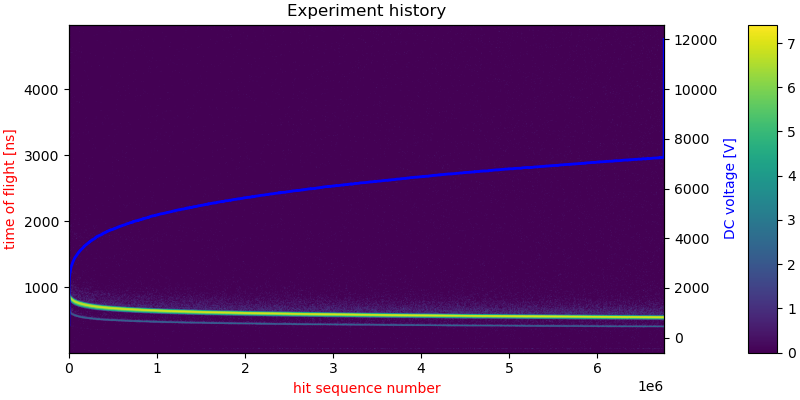

In [25]:
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, save_name = variables.result_path + '//ex_hist_' + dataset_name)

$\text{Boundaries of the selected(cropped) part of the graph is printed below}$

In [26]:
# Crop the dataset
print('Min Idx:', variables.selected_x1, 'Max Idx:', variables.selected_x2)
data_crop = data_loadcrop.crop_dataset(dld_group_storage)

Min Idx: 196515.72132740263 Max Idx: 6748848.291798759


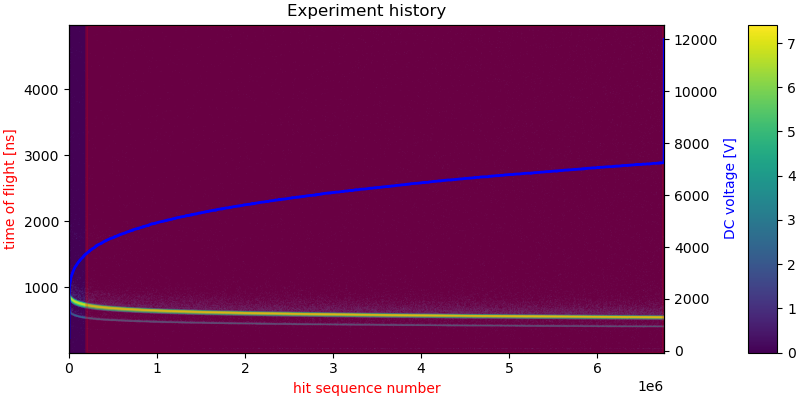

In [27]:
# Plot and selected experiment history
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, rect=True, save_name=variables.result_path + '//ex_hist_slected_' + dataset_name)

$\textbf {ROI selcetion}$
<br>
<br>
$\text {Select the region of maximum concentration of electrons in the below plotted graph to utlize relevant data}$

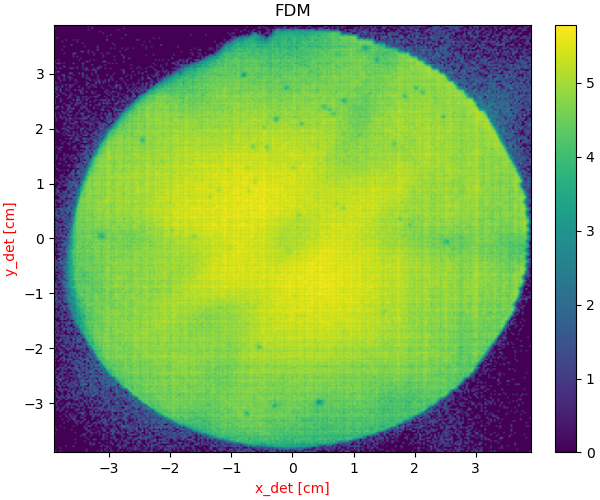

In [28]:
# Plot and select the FDM
data_loadcrop.plot_crop_FDM(data_crop,  bins=(256,256), save_name = variables.result_path + '//FDM_' + dataset_name)

$\text {The region selected in the previous step is displayed below.}$

x: 0.07142311630903242 y: -0.12963723373883962 roi: 3.638922071771928


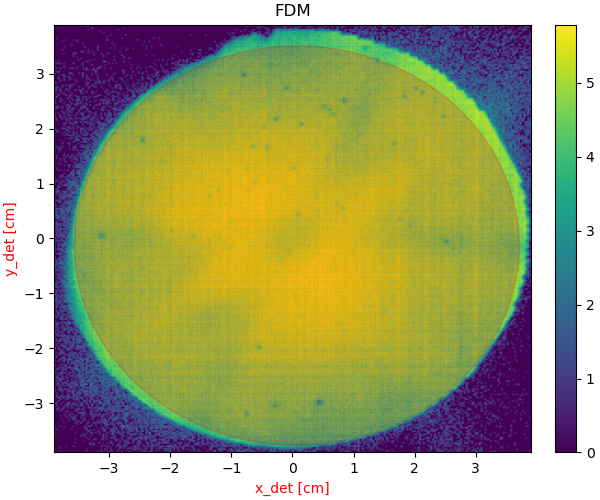

In [29]:
# plot selected area in FDM
data_loadcrop.plot_crop_FDM(data_crop, bins=(256,256), save_name = variables.result_path + '//FDM_c_' + dataset_name, circle=True)

$\text {The final selected data after processing is shown below.}$

d:\pyccapt\pyccapt\calibration\calibration_tools\data_loadcrop.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop.drop(np.where(mask_fdm)[0], inplace=True)


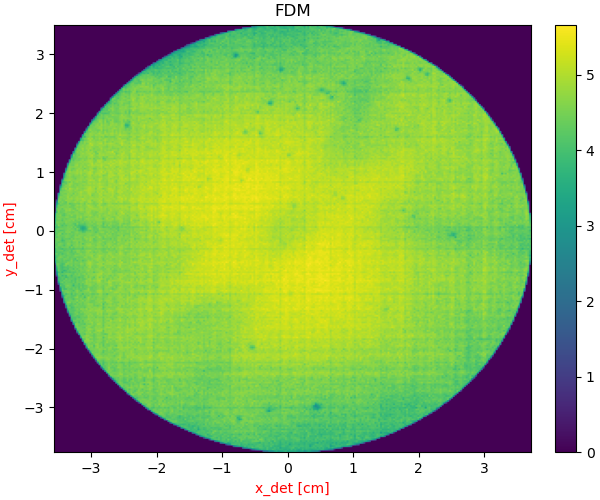

In [30]:
# Crop and plot the dataset
data_crop_FDM = data_loadcrop.crop_data_after_selection(data_crop)
data_loadcrop.plot_crop_FDM(data_crop_FDM, bins=(256,256), save_name = variables.result_path + '//FDM_crop_' + dataset_name, only_plot=True)

In [31]:
# calculate Pulses since last event pulse and Ions per pulse
counter = data_crop_FDM['start_counter'].to_numpy()

pulse_pi = np.zeros(len(counter))
ion_pp = np.zeros(len(counter))
temp = counter[0]
multi_hit_count = 1
pulse_to_previous_ion = 0
for i in range(len(counter)):

    if i+2 > len(counter):
        ion_pp[i] = multi_hit_count
        pulse_pi[i] = counter[i] - counter[i-1]
    else:
        if temp == counter[i+1]:
            multi_hit_count = multi_hit_count + 1
        else:
            if i != 0:
                temp = counter[i-1]
                pulse_to_previous_ion = counter[i] - temp
            else:
                pulse_to_previous_ion = 0
            for j in range(multi_hit_count):
                if j == 0:
                    ion_pp[i+j] = multi_hit_count
                    pulse_pi[i+j] = pulse_to_previous_ion
                elif j != 0 or i == 0:
                    ion_pp[i+j] = 0
                    pulse_pi[i+j] = 0
            multi_hit_count = 1


# add two calculated array to the croped dataset
data_crop_FDM['pulse_pi'] = pulse_pi.astype(np.uintc)
data_crop_FDM['ion_pp'] = ion_pp.astype(np.uintc)


C:\Users\APTUser\AppData\Local\Temp\ipykernel_25464\3416479450.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM['pulse_pi'] = pulse_pi.astype(np.uintc)
C:\Users\APTUser\AppData\Local\Temp\ipykernel_25464\3416479450.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM['ion_pp'] = ion_pp.astype(np.uintc)


$\text {The final dataset is saved and the percentage of loss in TOF croption is prited.}$

In [32]:
# save the cropped data

print('tof Crop Loss {:.2f} %'.format(((1 - len(data_crop_FDM) / len(dld_group_storage)) * 100)))

tof Crop Loss 7.54 %


In [33]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data_crop_FDM['high_voltage (V)'].to_numpy()
if pulse_mode_ini == 'voltage':
    dld_pulseVoltage = data_crop_FDM['pulse (V)'].to_numpy()
elif pulse_mode_ini == 'laser':
    dld_pulseVoltage = data_crop_FDM['pulse (deg)'].to_numpy()
dld_t = data_crop_FDM['t (ns)'].to_numpy()
dld_x = data_crop_FDM['x_det (cm)'].to_numpy()
dld_y = data_crop_FDM['y_det (cm)'].to_numpy()

mc_seb_ini = mc_tools.tof2mc(dld_t, t0_d.value, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength_d.value, mode=pulse_mode_ini)

data_crop_FDM.insert(0, 'x (nm)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(1, 'y (nm)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(2,'z (nm)', np.zeros(len(mc_seb_ini)))

data_crop_FDM.insert(3,'mc_c (Da)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(4, 'mc (Da)', mc_seb_ini)

data_crop_FDM.insert(9,'t_c (nm)', np.zeros(len(mc_seb_ini)))

In [34]:
data_crop_FDM

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,0.0,26.651289,3738.356445,3738.356445,10164.0,721.125558,0.0,0.299265,-0.264245,0,1
1,0.0,0.0,0.0,0.0,26.623950,3738.356445,3738.356445,10264.0,721.297008,0.0,0.117796,-0.576245,100,1
2,0.0,0.0,0.0,0.0,26.947230,3738.356445,3738.356445,10318.0,725.356944,0.0,0.073224,-0.585796,54,1
3,0.0,0.0,0.0,0.0,26.543927,3738.356445,3738.356445,10384.0,723.923622,0.0,0.397959,1.228898,66,1
4,0.0,0.0,0.0,0.0,263.962570,3738.356445,3738.356445,10556.0,2164.617972,0.0,-0.630367,0.694041,172,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6252145,0.0,0.0,0.0,0.0,26.359344,7246.866211,7246.866211,18886.0,551.760390,0.0,-1.980245,-2.753878,152,1
6252146,0.0,0.0,0.0,0.0,27.402419,7246.866211,7246.866211,18913.0,557.308512,0.0,-1.744653,-2.502367,27,1
6252147,0.0,0.0,0.0,0.0,28.061340,7246.866211,7246.866211,19050.0,564.276240,0.0,-2.999020,-0.885061,137,1
6252148,0.0,0.0,0.0,0.0,27.803238,7246.866211,7246.866211,19225.0,547.103808,0.0,-1.149306,0.986939,175,1


In [35]:
data_crop_FDM.dtypes

x (nm)              float64
y (nm)              float64
z (nm)              float64
mc_c (Da)           float64
mc (Da)             float64
high_voltage (V)    float64
pulse (V)           float64
start_counter       float64
t (ns)              float64
t_c (nm)            float64
x_det (cm)          float64
y_det (cm)          float64
pulse_pi             uint32
ion_pp               uint32
dtype: object

In [36]:
# save the dataset to hdf5 file
hierarchyName = 'df'
data_tools.store_df_to_hdf(savename, data_crop_FDM, hierarchyName)

In [37]:
# save data as epos file
epos = ccapt_tools.ccapt_to_epos(data_crop_FDM, path=variables.result_path, name=dataset_name + '.epos')
pos = ccapt_tools.ccapt_to_pos(data_crop_FDM, path=variables.result_path, name=dataset_name + '.pos')

In [21]:
# save data in csv format
data_tools.store_df_to_csv(data_crop_FDM, variables.result_path + dataset_name + '.csv')